## Install deps

In [ ]:
!pip install pandas numpy requests matplotlib
!pip install tf-agents
!pip install tf-keras

In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

### Download the dataset from my netlify deployment. As Collab is ephemeral
And I am lazy to spin up new nginx on my traefik host at home

In [2]:
import requests
base_url = "https://dc-bandits-ab-06e963.netlify.app/dataset-"
files = ["zakladni.csv","discovery.csv","segment.csv"]

for file in files:
  response = requests.get(base_url+file, stream=True)
  with open(file,'wb') as output:
    output.write(response.content)

## Data preparation
Aggregate the data by 30 minutes intervals

In [3]:
import pandas as pd
import numpy as np

data = pd.DataFrame()
for file in files:
  variant = pd.read_csv(file)
  variant['hour'] = pd.to_datetime(variant['hour'])
  variant.set_index('hour', inplace=True)
  variant = variant.resample('24h').agg({'visits':'sum', 'clicks':'sum'}).dropna()

  variant.index.rename("interval", inplace=True)
  variant['variant'] = file.replace(".csv", "")
  print(variant['visits'].sum())
  # Precompute CTR
  variant['CTR'] = variant['clicks'] / variant['visits']
  
  data = pd.concat([data, variant])
print(data.head())
print(data.tail())

28966
29001
29066
                     visits  clicks   variant       CTR
interval                                               
2023-03-06 12:00:00     160       1  zakladni  0.006250
2023-03-06 18:00:00     459      15  zakladni  0.032680
2023-03-07 00:00:00     113      10  zakladni  0.088496
2023-03-07 06:00:00     516      15  zakladni  0.029070
2023-03-07 12:00:00     674      29  zakladni  0.043027
                     visits  clicks  variant       CTR
interval                                              
2023-03-23 12:00:00     658      16  segment  0.024316
2023-03-23 18:00:00     423      14  segment  0.033097
2023-03-24 00:00:00     126       7  segment  0.055556
2023-03-24 06:00:00     522      20  segment  0.038314
2023-03-24 12:00:00     144      14  segment  0.097222


## Prepare Tensorflow Bandit Agents

In [4]:
import tensorflow as tf

from tf_agents.bandits.environments.bandit_py_environment import BanditPyEnvironment
from tf_agents.specs import array_spec


class ABCTestBanditEnv(BanditPyEnvironment):
    def __init__(self, data):
        self.data = data
        self.current = 0

        # Num of A/B variants (actions)
        self.variants = data['variant'].unique()
        action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=len(self.variants) - 1, name='action')

        # Define observation as a vector of the day of the week (0-6) and hour of the day (0-23)
        observation_spec = array_spec.ArraySpec(
            shape=(2,), dtype=np.int32, name='observation')

        super(ABCTestBanditEnv, self).__init__(observation_spec, action_spec)

        # Normalize day and hour for observations
        self.data['day_of_week'] = self.data.index.dayofweek
        self.data['hour_of_day'] = self.data.index.hour

    def _observe(self):
        if self.current >= len(self.data):
            self.current = 0 
            
        # Pass day, hour from curr interval to the observation module
        obs_data = self.data.iloc[self.current]
        self._observation = np.array([obs_data['day_of_week'], obs_data['hour_of_day']], dtype='int32')
        return self._observation

    def _apply_action(self, action):
        # Chosen variant
        variant_data = self.data[self.data['variant'] == self.variants[action]]
        if variant_data.empty:
            reward = 0
        else:
            ctr = variant_data['CTR'].values[0]
            # Simulate a visit
            reward = np.random.choice([0, 1], p=[1-ctr, ctr])  # Reward is 0 or 1 based on the variant CTR
        self.current += 1
        return reward




2024-06-14 20:55:26.738122: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 20:55:26.738744: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 20:55:26.741031: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 20:55:26.767756: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 20:55:27.221671: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [5]:
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

# Create the environment
env = ABCTestBanditEnv(data)
env = tf_py_environment.TFPyEnvironment(env)

# Define time_step_spec and action_spec
time_step_spec = env.time_step_spec()
action_spec = env.action_spec()

# Initialize the agent
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    alpha=0.5,  # Adjust exploration level
    tikhonov_weight=1.0,  # Regularization to prevent overfitting
    dtype=tf.float32
)

# Setup Replay Buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=env.batch_size,
    max_length=1000)

actions_taken = []

# Function to collect data from interactions
def collect_step(env, policy):
    time_step = env.current_time_step()
    action_step = policy.action(time_step)
    # Log
    actions_taken.append(action_step.action.numpy())
    next_time_step = env.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

# Training Loop
num_iterations = data['visits'].sum()
print(num_iterations)
for _ in range(num_iterations):
    # Collect data from the environment
    collect_step(env, agent.policy)

    # Sample a batch of data from the buffer and update the agent's network
    experience = replay_buffer.gather_all()
    train_loss = agent.train(experience)
    replay_buffer.clear()

    print(f"Step: {_}, Loss: {train_loss.loss.numpy()}")

print("Training completed.")

87033
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
Step: 0, Loss: 0.0
Step: 1, Loss: 0.0
Step: 2, Loss: 0.0
Step: 3, Loss: 0.0
Step: 4, Loss: 0.0
Step: 5, Loss: 0.0
Step: 6, Loss: 0.0
Step: 7, Loss: 0.0
Step: 8, Loss: 0.0
Step: 9, Loss: 0.0
Step: 10, Loss: 0.0
Step: 11, Loss: 0.0
Step: 12, Loss: 0.0
Step: 13, Loss: 0.0
Step: 14, Loss: 0.0
Step: 15, Loss: 0.0
Step: 16, Loss: 0.0
Step: 17, Loss: 0.0
Step: 18, Loss: 0.0
Step: 19, Loss: 0.0
Step: 20, Loss: 0.0
Step: 21, Loss: 0.0
Step: 22, Loss: 0.0
Step: 23, Loss: 0.0
Step: 24, Loss: 0.0
Step: 25, Loss: 0.0
Step: 26, Loss: 0.0
Step: 27, Loss: 0.0
Step: 28, Loss: 0.0
Step: 29, Loss: 0.0
Step: 30, Loss: 0.0
Step: 31, Loss: 0.0
Step: 32, Loss: 0.0
Step: 33, Loss: 0.0
Step: 34, Loss: 0.0
Step: 35, Loss: 0.0
Step: 36, Loss: 0.0
Step: 37, Loss: 0.0
Step: 38, Loss: 0.0
Step: 39, Loss: 0.0
Step: 40, Loss: 0.0
Step: 41, Loss: 0.0
Step: 42, Loss: 0.0
Step: 43, Loss: 0.0
Step: 44, Loss: 0.0
Step: 45, Loss

       zakladni  discovery    segment
step                                 
87032  3.835327  70.390542  25.774132


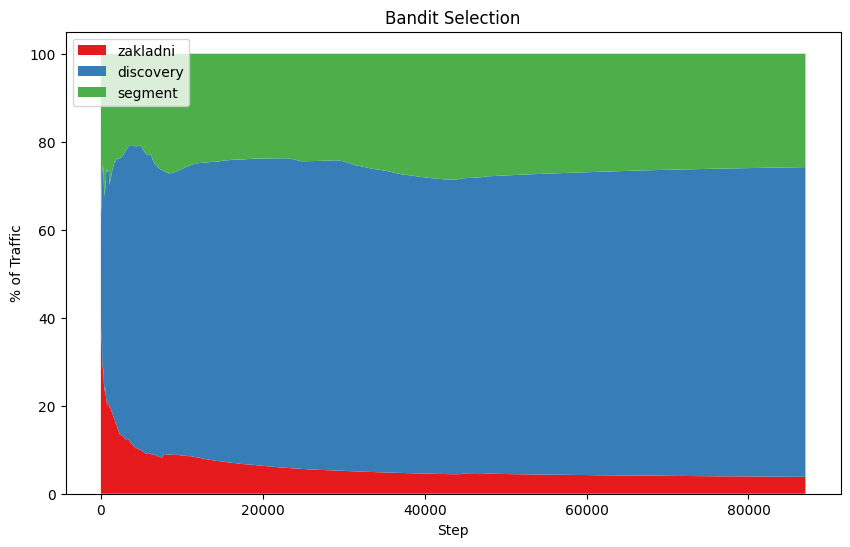

In [6]:
import matplotlib.pyplot as plt

actions_df = pd.DataFrame(actions_taken, columns=['action'])
actions_df['step'] = actions_df.index

# Count the occurrences of each action at each step
actions_count_df = actions_df.groupby(['step', 'action']).size().unstack(fill_value=0)

# Calculate the cumulative sum to get the traffic over time
cumulative_counts = actions_count_df.cumsum()

# Calculate the percentage of traffic allocated to each variant
cumulative_percents = cumulative_counts.div(cumulative_counts.sum(axis=1), axis=0) * 100

cumulative_percents.columns = data['variant'].unique()
print(cumulative_percents.tail(1), )
# Plotting the area chart
plt.figure(figsize=(10, 6))
plt.stackplot(cumulative_percents.index, cumulative_percents.T, labels=cumulative_percents.columns, colors=['#e41a1c', '#377eb8', '#4daf4a'])
plt.legend(loc='upper left')
plt.xlabel('Step')
plt.ylabel('% of Traffic')
plt.title('Bandit Selection')
plt.show()

In [ ]:
def simulate_clicks(row):
    visits = int(row['visits'])
    clicks = int(row['clicks'])
    if visits == 0:
        probability
    else:
        probability = clicks / visits
    # Bernoulliho schéma
    clicks = np.random.binomial(1, probability, visits)
    return clicks

Add rewards simulation